In [13]:
#!/usr/bin/env python3
import os
import numpy as np
import pathlib
import matplotlib.pyplot as plt
from IPython.display import clear_output

from src.architecture import SegmentationModel

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing.image import array_to_img, load_img, save_img
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam



%matplotlib inline

### Build the model structure

Notes: https://stackoverflow.com/questions/47787011/how-to-disable-dropout-while-prediction-in-keras

In [19]:
input_shape = (375, 1242, 3)

In [20]:
fm_model = SegmentationModel(input_shape).segmentation_model

In [21]:
fm_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 375, 1242, 3 0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 375, 1242, 64 1792        inputs[0][0]                     
__________________________________________________________________________________________________
conv1_2 (Conv2D)                (None, 375, 1242, 64 36928       conv1_1[0][0]                    
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 188, 621, 64) 0           conv1_2[0][0]                    
____________________________________________________________________________________________

### Load VGG16 model weights up to conv5_3

In [22]:
keras_vgg16 = VGG16()

In [23]:
MAX_POOL1 = 3
MAX_POOL2 = 6
MAX_POOL3 = 10
MAX_POOL4 = 14
max_pool_indices = [MAX_POOL1, MAX_POOL2, MAX_POOL3, MAX_POOL4] 

In [24]:
for i in range(1, 17):
    if i in max_pool_indices:
        continue
    else:
        weights = keras_vgg16.get_layer(index=i).get_weights()
        fm_model.get_layer(index=i).set_weights(weights)

# Prepare the model for training

Before training with the Kitti road dataset, it was further processed. In particular the masks were cleaned from a third shade so that two colors remain, representing street and no-street areas. Also the folder structure was changed: The training folder consists of the folders `training_frames`, `training_masks`, `validation_frames` and `validation_masks`.

The images are splitted in ~80% (231 images) training data and ~20% (58 images) validation data.

In [25]:
LEARNING_RATE = 1e-05
EPSILON = 1e-05

In [26]:
fm_model.compile(optimizer=Adam(learning_rate=LEARNING_RATE, epsilon=EPSILON), loss=CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# Prepare the training data

In [27]:
def map_to_masks(frame_directory):
    frame = tf.io.read_file(frame_directory)
    frame = tf.image.decode_png(frame, channels=3)
    frame = tf.image.convert_image_dtype(frame, tf.uint8)

    mask_directory = tf.strings.regex_replace(input=frame_directory, pattern='frames', rewrite=('masks'))
    
    mask = tf.io.read_file(mask_directory)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.convert_image_dtype(mask, tf.uint8)
    mask = tf.where(mask == 255, np.dtype('uint8').type(0), mask)
    
    return {'frame': frame, 'mask': mask}

In [28]:
training_directory = 'kitti_road_data/training/'

In [29]:
training_frames_directory = training_directory + 'training_frames'
training_frames_directory = pathlib.Path(training_frames_directory)
training_frames = tf.data.Dataset.list_files(str(training_frames_directory/'u*'))
training_data = training_frames.map(map_to_masks)

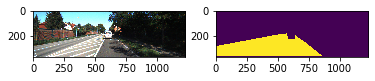

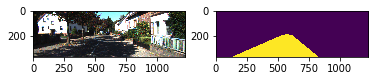

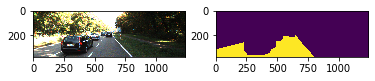

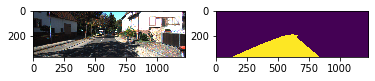

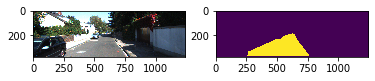

In [30]:
for index, image in enumerate(training_data.take(5)):
    plt.subplot(1, 2, 1)
    plt.imshow(array_to_img(image['frame']))
    plt.subplot(1, 2, 2)
    plt.imshow(array_to_img(image['mask']))
    plt.show()

In [31]:
validation_frames_directory = training_directory + 'validation_frames'
validation_frames_directory = pathlib.Path(validation_frames_directory)
validation_frames = tf.data.Dataset.list_files(str(validation_frames_directory/'u*'))
validation_data = validation_frames.map(map_to_masks)

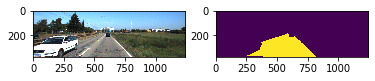

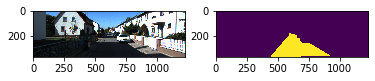

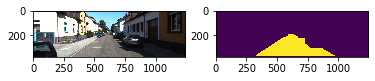

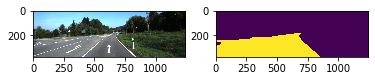

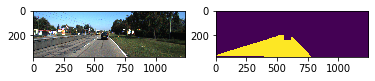

In [32]:
for index, image in enumerate(validation_data.take(5)):
    plt.subplot(1, 2, 1)
    plt.imshow(array_to_img(image['frame']))
    plt.subplot(1, 2, 2)
    plt.imshow(array_to_img(image['mask']))
    plt.show()

In [33]:
data_set = {'train': training_data, 'test': validation_data}

## Apply some data augmentation to the training data

The following functions are taken from: https://www.tensorflow.org/tutorials/images/segmentation<br>

In [34]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

In [35]:
@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['frame'], (375, 1242))
    input_mask = tf.image.resize(datapoint['mask'], (375, 1242))

    if (tf.random.uniform(()) > 0.5):
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [36]:
def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['frame'], (375, 1242))
    input_mask = tf.image.resize(datapoint['mask'], (375, 1242))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

# Training Hyperparameters

In [37]:
TRAIN_LENGTH = len(list(training_frames_directory.glob('**/*.png')))
BATCH_SIZE = 1
EPOCHS = 12000
VALIDATION_STEPS = 100
SAVE_CHECKPOINT_STEPS = 2000
SHOW_IMAGE = 150

BUFFER_SIZE = TRAIN_LENGTH + 1

# Prepare the data further

In [38]:
train = data_set['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = data_set['test'].map(load_image_test)

In [39]:
#train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat(count=3)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [40]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

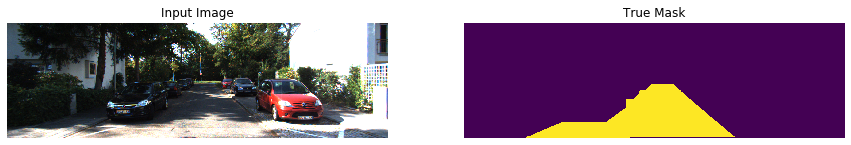

In [41]:
for image, mask in train.take(1):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [42]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [43]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask, create_mask(fm_model.predict(sample_image[tf.newaxis, ...]))])


In [44]:
class DisplayCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch % SHOW_IMAGE == 0):
            clear_output(wait=True)
            show_predictions()
            print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

## Define checkpoint callback

In [45]:
checkpoint_path = "fm_model_checkpoints/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [46]:
cp_callback = ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_freq=SAVE_CHECKPOINT_STEPS)

## Train the model and save intermediate results and the final version

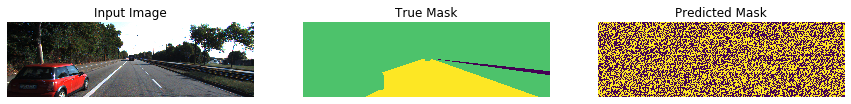


Sample Prediction after epoch 1

  4/231 [..............................] - ETA: 3:17:16 - loss: 128.6727 - accuracy: 0.4986

KeyboardInterrupt: 

In [80]:
model_history = fm_model.fit(train_dataset,
                             epochs=EPOCHS,
                             validation_steps=VALIDATION_STEPS,
                             validation_data=test_dataset,
                             callbacks=[DisplayCallback(), cp_callback])

In [47]:
fm_model.save(filepath='fm_model.h5')
fm_model.save_weights(filepath='fm_model_weights')